In [212]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import networks
import torch.nn.functional as F
import scipy.ndimage as ndimage
from torch.autograd import Variable
from networks import *
import numpy as np
import config as cf
import torch.optim as optim
from itertools import starmap
import math

In [213]:
sig = 1.0
#start_epoch, num_epochs, batch_size, optim_type = cf.start_epoch, cf.num_epochs, cf.batch_size, cf.optim_type


transform_test = transforms.Compose([
    transforms.ToTensor(),
])

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=False, transform=transform_test)
num_classes = 100
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

In [159]:
t = torch.zeros(3,32*32).unsqueeze(dim=0)

In [133]:
torch.zeros(3,32*32).unsqueeze(dim=0).shape

torch.Size([1, 3, 1024])

In [163]:
tlist = []
for i in testset:
    tlist.append(i[0].view(3,-1))

In [226]:
x = transforms.ToPILImage(testset)

(tensor([[[0.7804, 0.7686, 0.7647,  ..., 0.8471, 0.8510, 0.8784],
          [0.7725, 0.7647, 0.7647,  ..., 0.9059, 0.9137, 0.9451],
          [0.8706, 0.8353, 0.8196,  ..., 0.9529, 0.9569, 0.9804],
          ...,
          [0.2824, 0.2784, 0.2902,  ..., 0.8627, 0.7176, 0.6078],
          [0.2824, 0.2980, 0.3294,  ..., 0.8706, 0.7333, 0.5686],
          [0.3137, 0.3294, 0.3333,  ..., 0.8510, 0.8118, 0.6902]],
 
         [[0.8431, 0.8275, 0.8235,  ..., 0.9059, 0.9059, 0.9176],
          [0.8235, 0.8157, 0.8235,  ..., 0.9529, 0.9529, 0.9608],
          [0.8863, 0.8627, 0.8588,  ..., 0.9804, 0.9765, 0.9804],
          ...,
          [0.2863, 0.2902, 0.3059,  ..., 0.8157, 0.6588, 0.5529],
          [0.2941, 0.3176, 0.3490,  ..., 0.8314, 0.6824, 0.5176],
          [0.3333, 0.3529, 0.3608,  ..., 0.8118, 0.7608, 0.6431]],
 
         [[0.9765, 0.9569, 0.9529,  ..., 0.9804, 0.9804, 0.9882],
          [0.9373, 0.9333, 0.9412,  ..., 0.9804, 0.9804, 0.9922],
          [0.9647, 0.9490, 0.9529,  ...,

In [149]:
testset[0][0].view(3,-1).unsqueeze(dim=0).shape

torch.Size([1, 3, 1024])

In [165]:
tlist2 = torch.stack(tlist)

In [178]:
tlist2.mean(dim=2)

tensor([[0.6904, 0.6890, 0.7621],
        [0.4418, 0.4648, 0.3936],
        [0.3951, 0.4094, 0.4267],
        ...,
        [0.2974, 0.4166, 0.2514],
        [0.4081, 0.3758, 0.3122],
        [0.5622, 0.3674, 0.3300]])

In [62]:
checkpoint_gauss = torch.load("./checkpoint/cifar100/resnet-50_gaussian.t7")
checkpoint2 = torch.load("./checkpoint/cifar100/resnet-50_readouttest.t7")

net1 = checkpoint_gauss['net'].cpu()
net2 = checkpoint2['net'].cpu()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'networks.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'networks.resnet.Bottleneck' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [63]:
x = next(iter(testloader))

In [65]:
out = net1(x[0])

In [48]:
net1.eval()
test_loss = 0
correct = 0
total = 0

for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs, volatile=True), Variable(targets)
    #batch_var = np.append(batch_var, torch.std(inputs.cpu()).data)
    outputs = net1(inputs)

    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()

acc = 100.*correct/total
#variance = batch_var.mean()
print("| Test Result\tAcc@1: %.2f%%" %(acc))
std = 0.
for images, _ in testloader:
    batch_samples = images.size(0)
    #print(batch_samples)
    images = images.view(batch_samples,images.size(1), -1)
    #print(images.shape)
    std += images.std(2).sum(0)
    #print(std)
std /= len(testloader.dataset)
#print(std)
print(sig/std.mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


| Test Result	Acc@1: 1.00%
tensor(6.1658)


### Plotting Code

In [181]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import pandas as pd
import seaborn as sns

In [50]:
df = pd.DataFrame({'Noise level': [1.5434, 2.0139, 2.5142, 3.0436,3.6026,4.1929,4.8178, 5.4773, 
                                  6.1658], 'Robust Network': [68, 42,17,9,5,3,2,2,1], 'Retrained Network': [17, 9,5,4,3,2,2,1,1]})

In [1]:
df

NameError: name 'df' is not defined

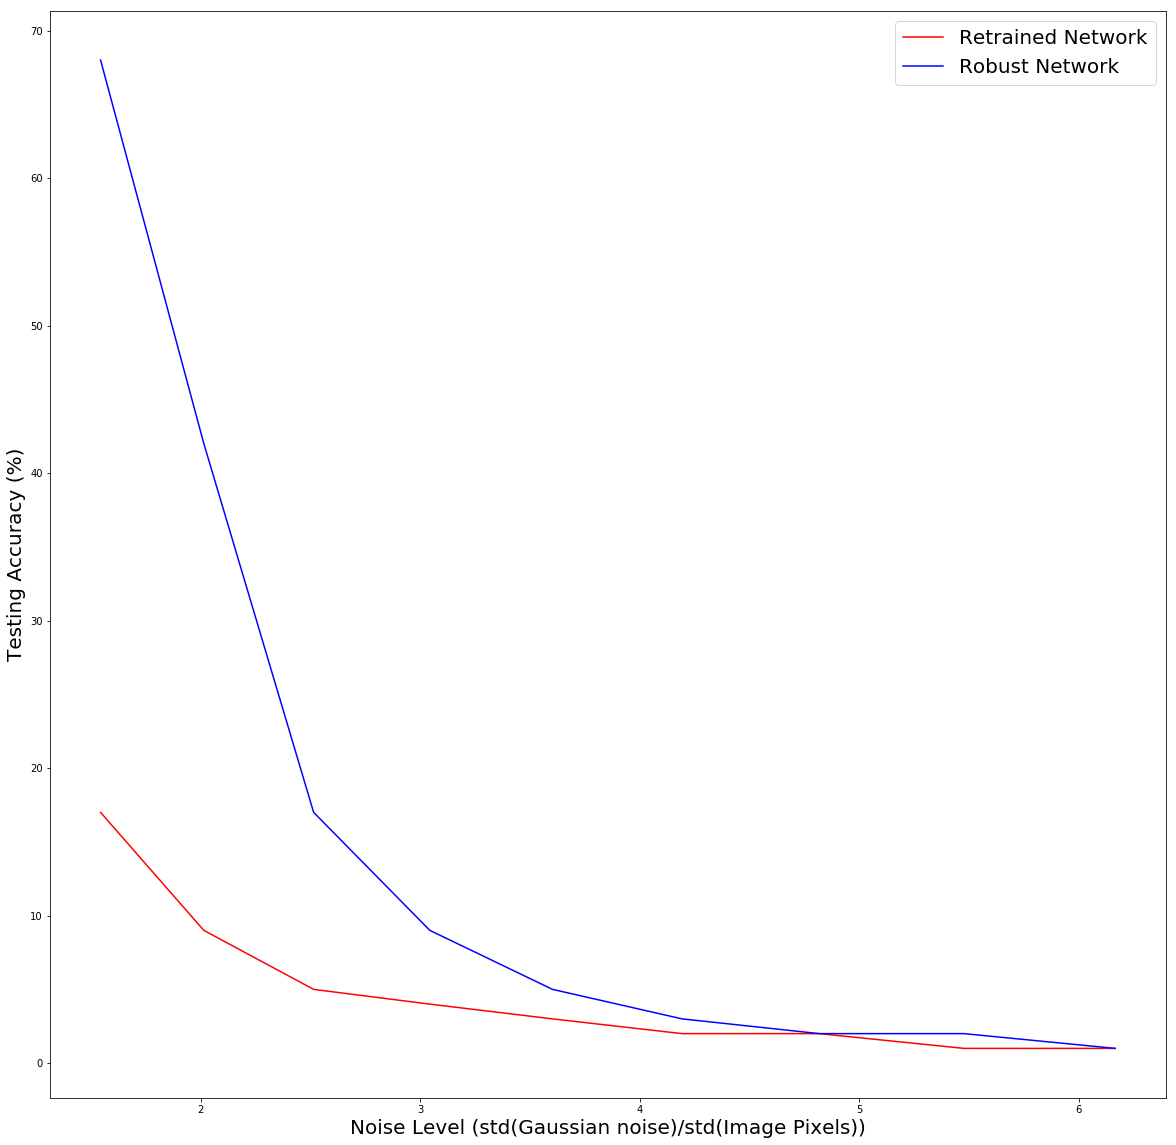

In [57]:
plt.figure(figsize=(20,20))
plt.xlabel('Noise Level (std(Gaussian noise)/std(Image Pixels))', fontsize=20)
plt.ylabel('Testing Accuracy (%)', fontsize=20)
plt.plot('Noise level', 'Retrained Network', data=df, color='red')
plt.plot('Noise level', 'Robust Network', data=df, color='blue')
plt.legend(fontsize=20)
plt.savefig("NvAcc")

In [3]:
acc = np.load("epoch_accs.npy")

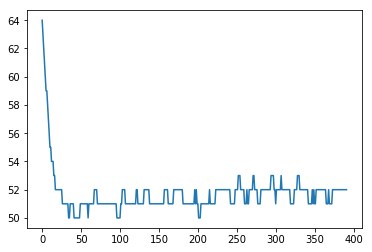

In [81]:
plt.plot(acc)

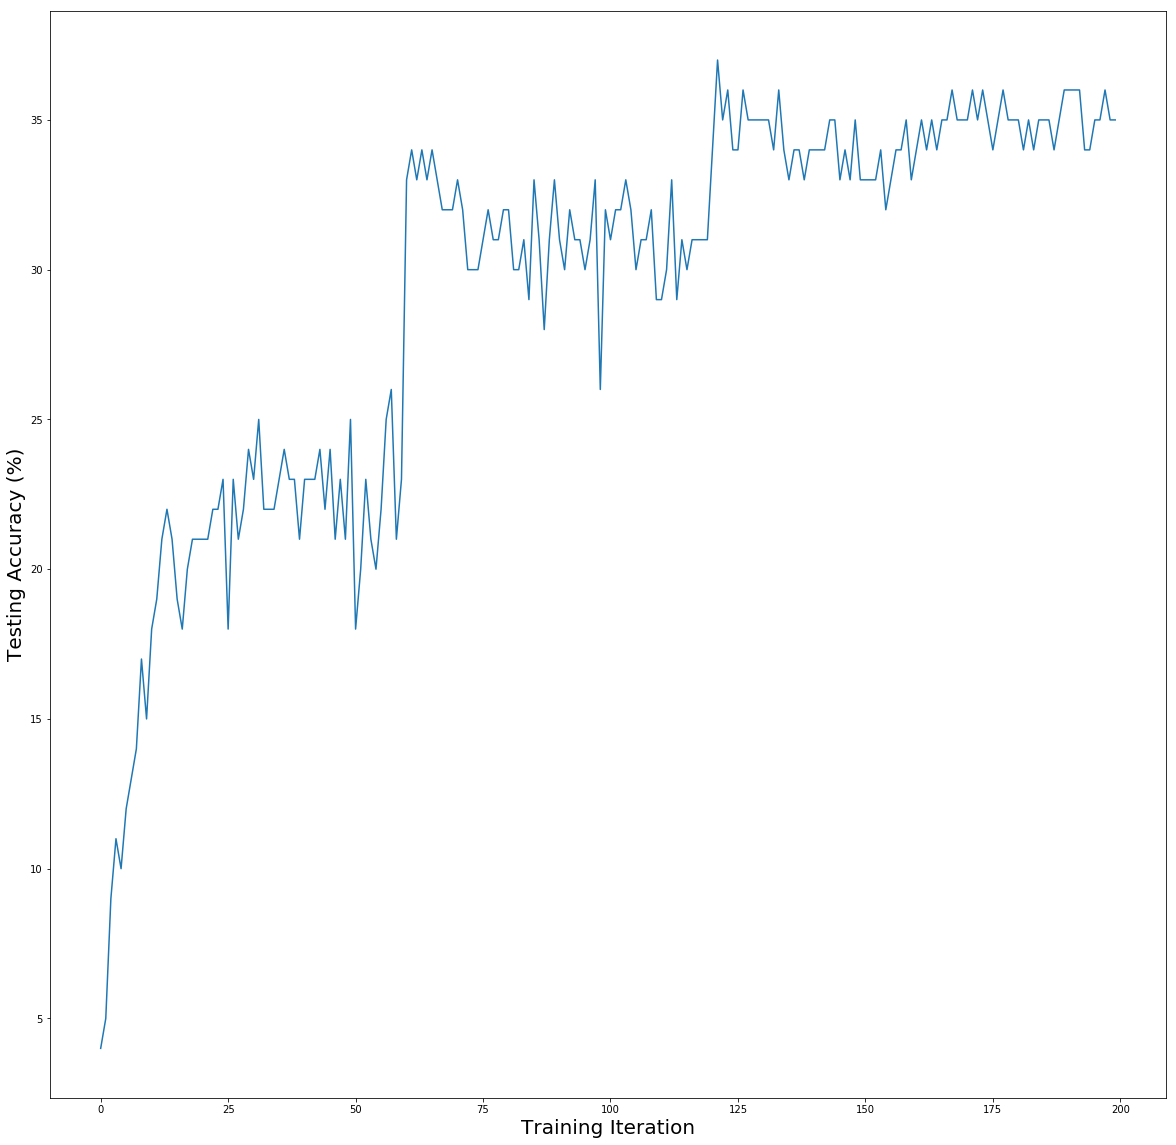

In [4]:
plt.figure(figsize=(20,20))
plt.xlabel('Training Iteration', fontsize=20)
plt.ylabel('Testing Accuracy (%)', fontsize=20)
plt.plot(acc)
#plt.savefig("evAcc")

In [11]:
accuracies = [67,64,56,24,11]

In [94]:
type(accuracies)

list

In [9]:
N = 5

ind = np.arange(N)

In [10]:
ind

array([0, 1, 2, 3, 4])

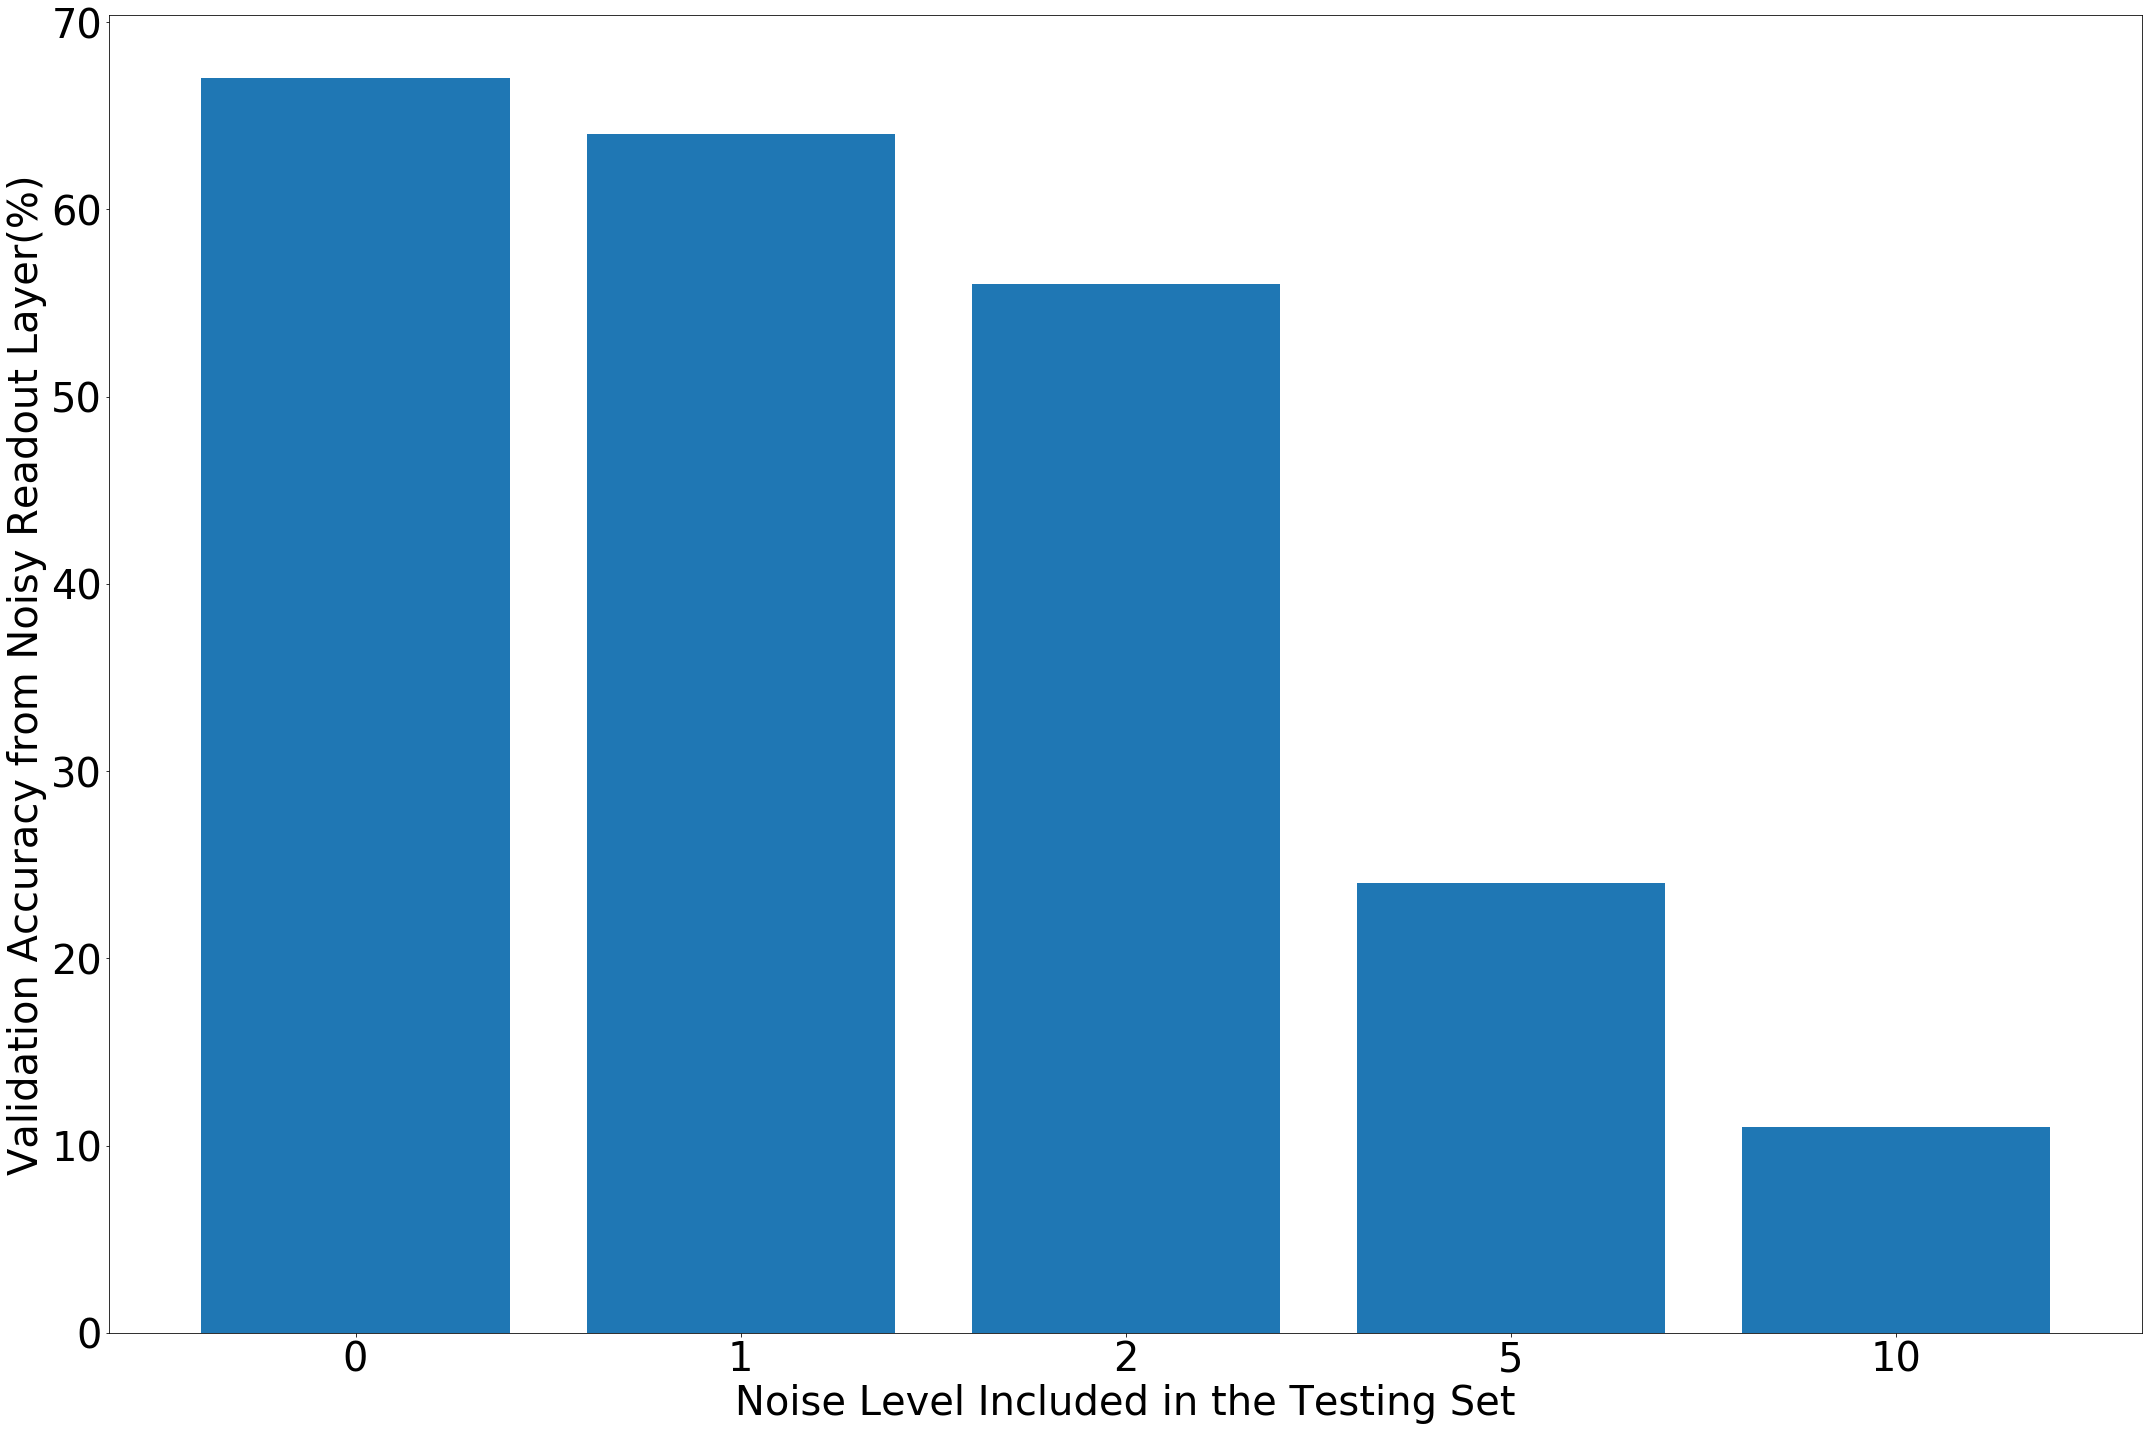

In [12]:
plt.figure(figsize=(30,20))
plt.bar(ind, accuracies, align='center')
plt.xticks(ind, ('0', '1', '2', '5', '10'), fontsize=40)
plt.xlabel("Noise Level Included in the Testing Set", fontsize=40)
plt.ylabel("Validation Accuracy from Noisy Readout Layer(%)", fontsize=40)
plt.yticks(fontsize=40)
plt.tight_layout()
plt.savefig("Noise Levels vs Validation Accuracy (Noisy Readout Layer Only+Trained Clean+Single)")

In [97]:
len(ind)

10

In [98]:
len(accuracies)

9

In [2]:
import seaborn as sns

In [216]:
df2 = pd.read_csv("./plotting data/Single Noise Level vs Validation Accuracy - Sheet1.csv")

In [215]:
net_order = ['Trained on Clean Images, no regularization','Robust (trained on noise-augmented images, no regularizer)',
'Robust (trained on noise-augmented images, no regularizer, retrained readout on clean images)',
'Robust (trained on noise-augmented images, readout matching regularizer, clean readout)',
'Robust (trained on noise-augmented images, readout matching regularizer, noise-augmented readout)',
'Robust (trained on noise-augmented images, readout matching regularizer, retrained clean readout)',
'Robust (trained on noise-augmented images, readout matching regularizer, retrained noise-augmented readout)',
'Trained on Clean Images, Similarity Regularization every 10th Convolution Layer',
'Trained on Noise-Augmented Images, Similarity Regularization every 10th Convolution Layer',
'Trained on Clean Images, Similarity Regularization every 10th Convolution Layer + Skip Connection Convolutions',
'Trained on Noise-Augmented Images, Similarity Regularization every 10th Convolution Layer + Skip Connection Convolutions',
'Trained on Clean Images, Similarity Regularization on all Convolution Layers with Single Regularization Strength',
'Trained on Noise-Augmented Images, Similarity Regularization on all Convolution Layers with Single Regularization Strength',
'Trained on Clean Images, Similarity Regularization on all Convolution Layers with Layerwise Regularization Strength (lambda=20, eta=0.02)',
'Trained on Clean Images, Similarity Regularization Every 10th Convolution Layer with Layerwise Regularization Strength (lambda=40, eta=0.02)']

In [182]:
net_order_int = ['Trained on Clean Images, no regularization','Robust (trained on noise-augmented images, no regularizer)',
'Robust (trained on noise-augmented images, no regularizer, retrained readout on clean images)',
'Robust (trained on noise-augmented images, readout matching regularizer, clean readout)',
'Robust (trained on noise-augmented images, readout matching regularizer, noise-augmented readout)',
'Robust (trained on noise-augmented images, readout matching regularizer, retrained clean readout)',
'Robust (trained on noise-augmented images, readout matching regularizer, retrained noise-augmented readout)',
'Trained on Clean Images, Similarity Regularization every 10th Convolution Layer']

In [238]:
sns.set_context(font_scale=5)
fsize=20
plt.figure(figsize=(320,100))

fig = sns.barplot(x="Noise Level", y="Accuracy", hue="Network", hue_order=net_order, data=df2)
#sns.set(font_scale=5)
fig.labelsize = 50
fig.set_xlabel("Level of Gaussian Noise Applied to Validation images", fontsize=2*90)
fig.set_ylabel("Validation Accuracy (%)", fontsize=2*90)
plt.legend(bbox_to_anchor=(0.5, -0.9), loc="lower center", borderaxespad=5.)
plt.setp(fig.get_legend().get_title(), fontsize=2*92)
plt.setp(fig.get_legend().get_texts(), fontsize=2*90)
plt.setp(fig.get_xticklabels(),fontsize=2*90)
plt.setp(fig.get_yticklabels(), fontsize=2*90)
fig.set_title("Validation Accuracies of Networks with Different Regularization Methods on Gaussian Noise Levels", fontsize=2*90)

plt.savefig("Validation Accuracies on Different Noise Levels (4)", bbox_inches = "tight")

In [187]:
def netplot(x, y, **kwargs):
    ax = plt.gca()
    data=kwargs.pop("data")
    data.plot.scatter(x=x, y=y, ax=ax, **kwargs)
    data.plot.bar(x=x, y=y, ax=ax, grid=False, **kwargs)
    

g = sns.FacetGrid(df3, col="Network", col_wrap=1, height=10, col_order=net_order)
g.map_dataframe(netplot, 'Noise Level', 'Accuracy')
plt.tight_layout()
plt.savefig("Intermediate Plot 1 Test")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


TypeError: object of type 'NoneType' has no len()

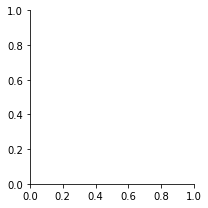

In [17]:
g = sns.FacetGrid(df2, hue='Network', hue_order=net_order)
g = g.map(sns.factorplot(kind="bar"), 'Noise Level', 'Accuracy')
g = g.map(sns.pointplot, 'Noise Level', 'Accuracy')

In [ ]:
[df2['Noise Level']

In [44]:
fig

In [138]:
%matplotlib inline

In [133]:
df3 = pd.read_csv("Subplot - Sheet1.csv")

In [34]:
len(list(set(df2["Network"])))

12

In [35]:
len(net_order)

12

In [167]:
df3['Accuracy'][6]=49

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [184]:
df3 = df2[df2.Network.isin(net_order_int)]

In [78]:
n = pd.Series(net_order)

In [185]:
df3

Noise Level  Accuracy                                            Network
0             0        72         Trained on Clean Images, no regularization
1             1        14         Trained on Clean Images, no regularization
2             2         2         Trained on Clean Images, no regularization
3             5         1         Trained on Clean Images, no regularization
4            10         1         Trained on Clean Images, no regularization
5             0        69  Robust (trained on noise-augmented images, rea...
6             1        55  Robust (trained on noise-augmented images, rea...
7             2        32  Robust (trained on noise-augmented images, rea...
8             5        12  Robust (trained on noise-augmented images, rea...
9            10         5  Robust (trained on noise-augmented images, rea...
10            0        69  Robust (trained on noise-augmented images, rea...
11            1        55  Robust (trained on noise-augmented images, rea...
12            2        32  Robust (trained on noise-augmented images, rea...
13            5        12  Robust (trained on noise-augmented images, rea...
14           10         5  Robust (trained on noise-augmented images, rea...
15            0        69  Robust (trained on noise-augmented images, rea...
16            1        55  Robust (trained on noise-augmented images, rea...
17            2        32  Robust (trained on noise-augmented images, rea...
18            5        12  Robust (trained on noise-augmented images, rea...
19           10         5  Robust (trained on noise-augmented images, rea...
20            0        69  Robust (trained on noise-augmented images, rea...
21            1        55  Robust (trained on noise-augmented images, rea...
22            2        32  Robust (trained on noise-augmented images, rea...
23            5        12  Robust (trained on noise-augmented images, rea...
24           10         5  Robust (trained on noise-augmented images, rea...
25            0        48  Robust (trained on noise-augmented images, no ...
26            1        14  Robust (trained on noise-augmented images, no ...
27            2        11  Robust (trained on noise-augmented images, no ...
28            5         5  Robust (trained on noise-augmented images, no ...
29           10         5  Robust (trained on noise-augmented images, no ...
30            0        63  Robust (trained on noise-augmented images, no ...
31            1        62  Robust (trained on noise-augmented images, no ...
32            2        55  Robust (trained on noise-augmented images, no ...
33            5        23  Robust (trained on noise-augmented images, no ...
34           10         9  Robust (trained on noise-augmented images, no ...
35            0        72  Trained on Clean Images, Similarity Regulariza...
36            1        14  Trained on Clean Images, Similarity Regulariza...
37            2         2  Trained on Clean Images, Similarity Regulariza...
38            5         1  Trained on Clean Images, Similarity Regulariza...
39           10         1  Trained on Clean Images, Similarity Regulariza...

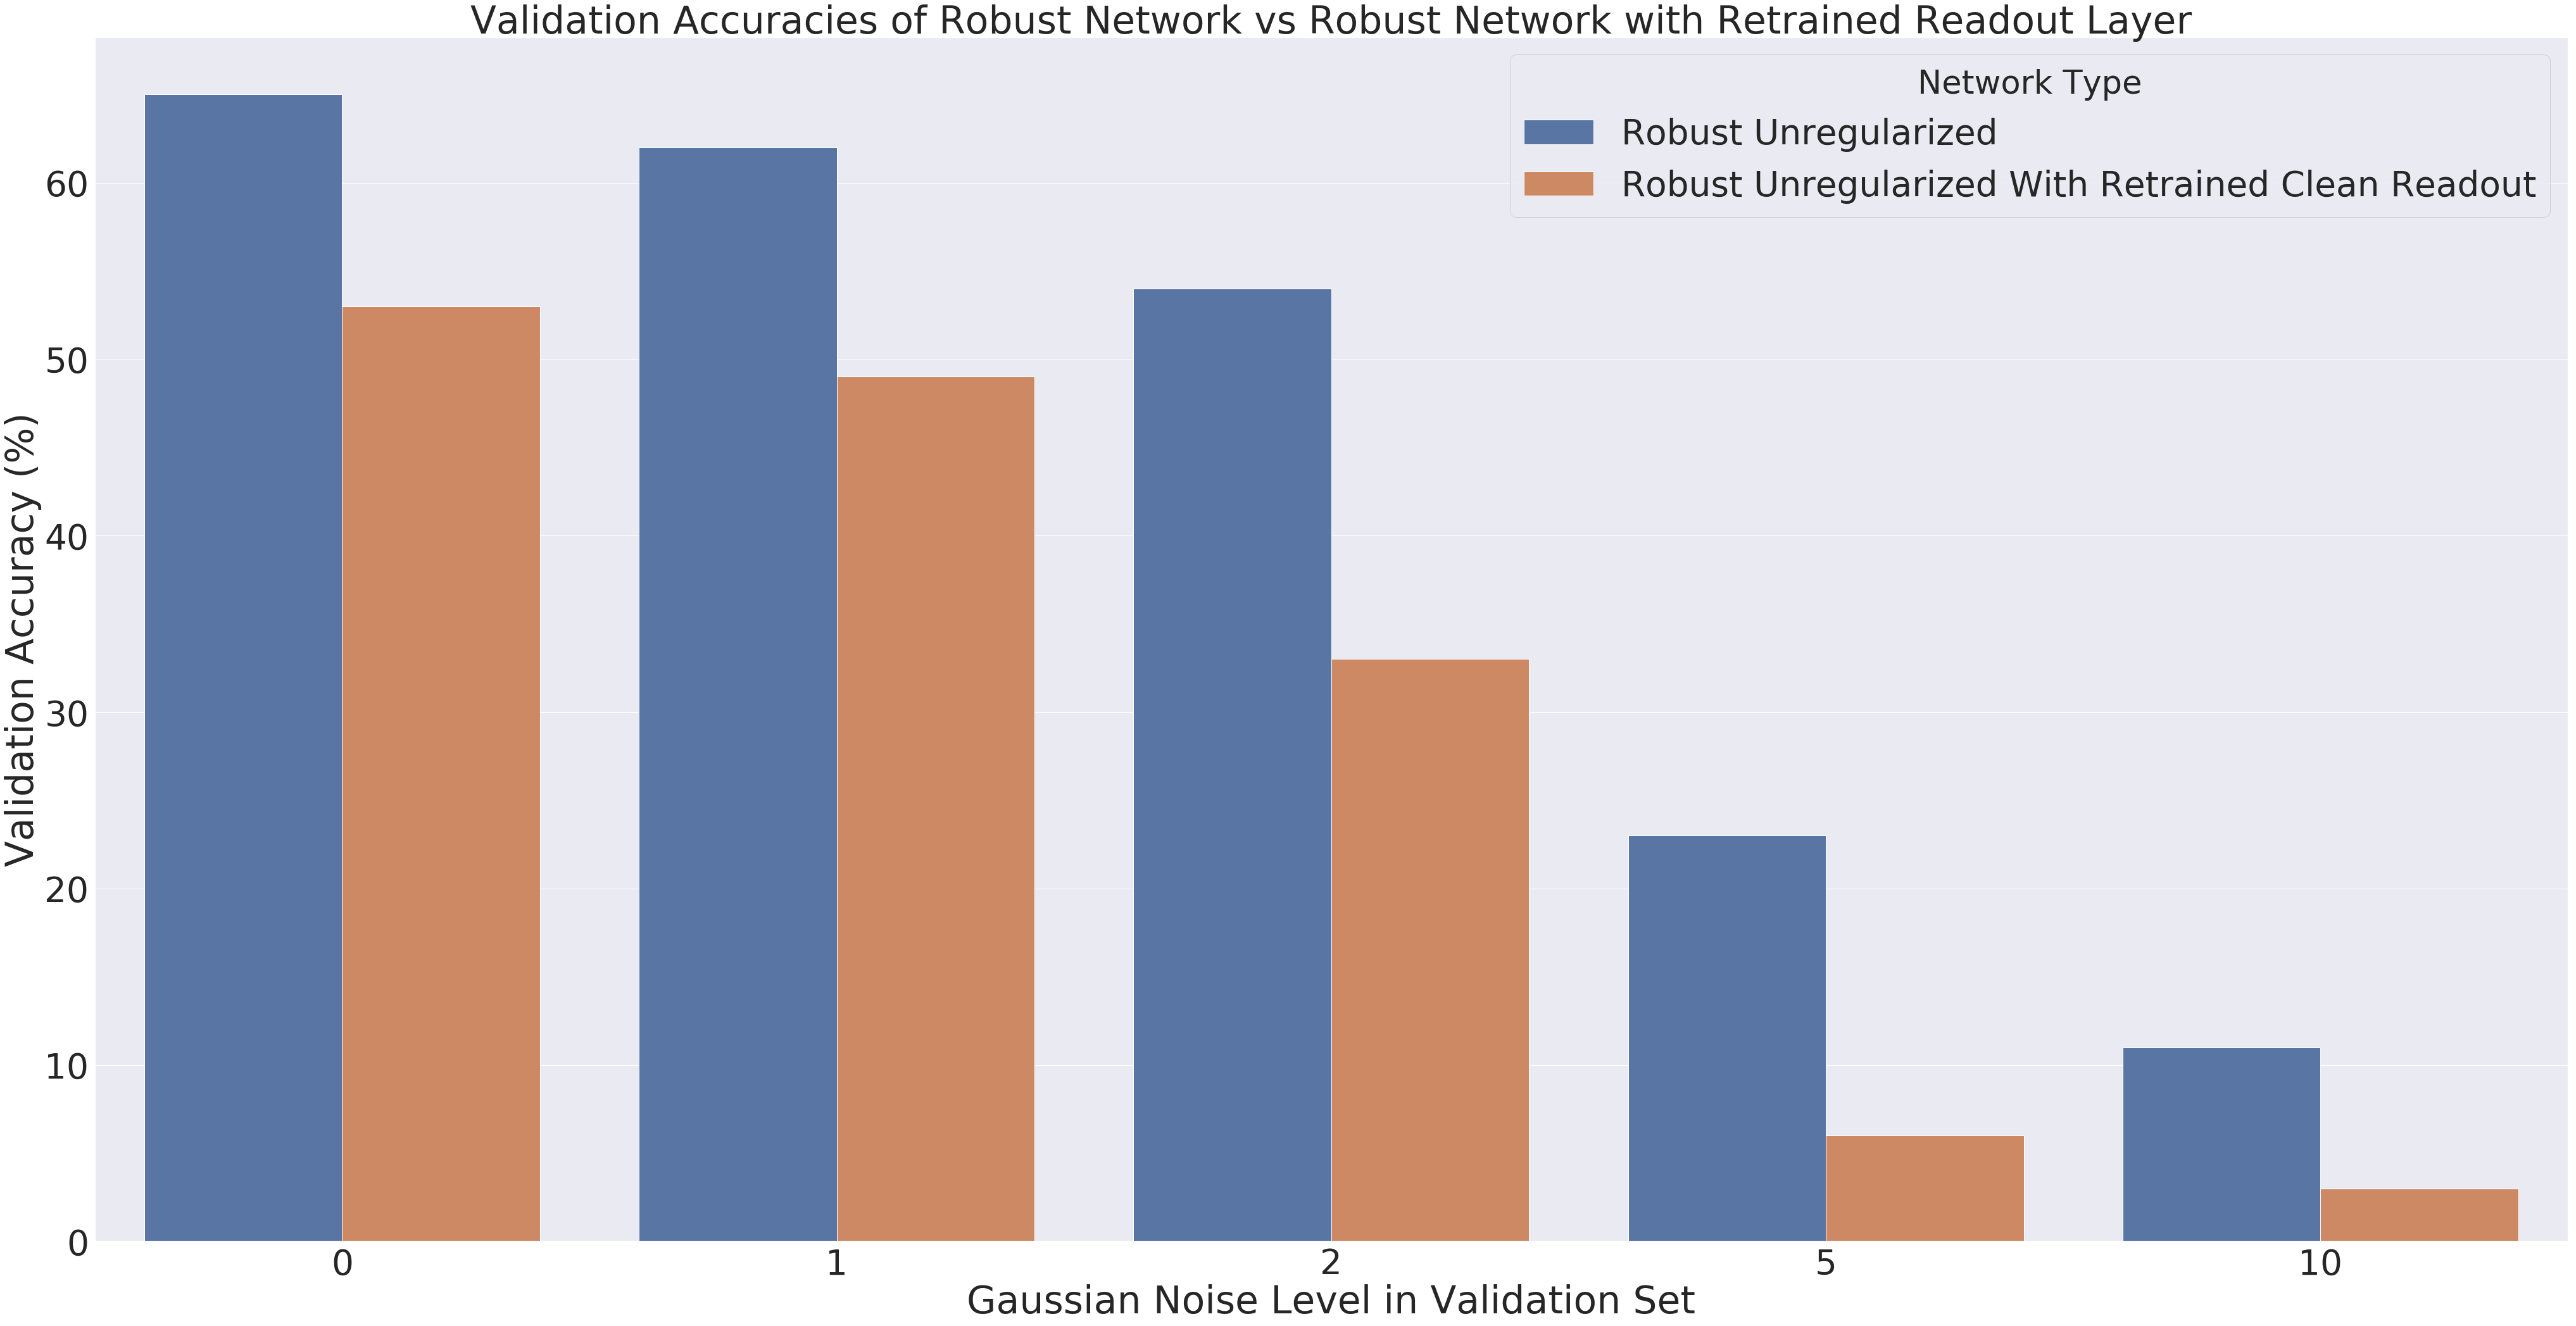

In [169]:
plt.figure(figsize=(70,35))
sns.set(font_scale=5)
#sns.set_context(font_scale=40.0)
fig = sns.barplot(x="Noise Level", y="Accuracy", hue="Network Type", data=df3)
fig.set_xlabel("Gaussian Noise Level in Validation Set")
fig.set_ylabel("Validation Accuracy (%)")
fig.set_title("Validation Accuracies of Robust Network vs Robust Network with Retrained Readout Layer")
plt.savefig("robust_accuracies")

<Figure size 432x288 with 0 Axes>

In [139]:
fig

In [142]:
plt.show()

In [171]:
df4 = pd.read_csv("Single Noise Level vs Validation Accuracy - Sheet2.csv")

In [180]:
df4

Noise Level in Testing/Validation Set  Validation Accuracy (%)  \
0                                      0                       71   
1                                      1                       54   
2                                      2                       32   
3                                      5                        5   
4                                     10                        3   
5                                      0                       71   
6                                      1                       54   
7                                      2                       32   
8                                      5                        5   
9                                     10                        3   

                                             Network  
0  Robust (new regularizer, retrained clean readout)  
1  Robust (new regularizer, retrained clean readout)  
2  Robust (new regularizer, retrained clean readout)  
3  Robust (new regularizer, retrained clean readout)  
4  Robust (new regularizer, retrained clean readout)  
5            Robust (new regularizer, noisy readout)  
6            Robust (new regularizer, noisy readout)  
7            Robust (new regularizer, noisy readout)  
8            Robust (new regularizer, noisy readout)  
9            Robust (new regularizer, noisy readout)

In [188]:
df4['Network'][0:5] = "Robust (readout matching regularizer, retrained clean readout)"
df4['Network'][5:]= "Robust (readout matching regularizer, robust readout)"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


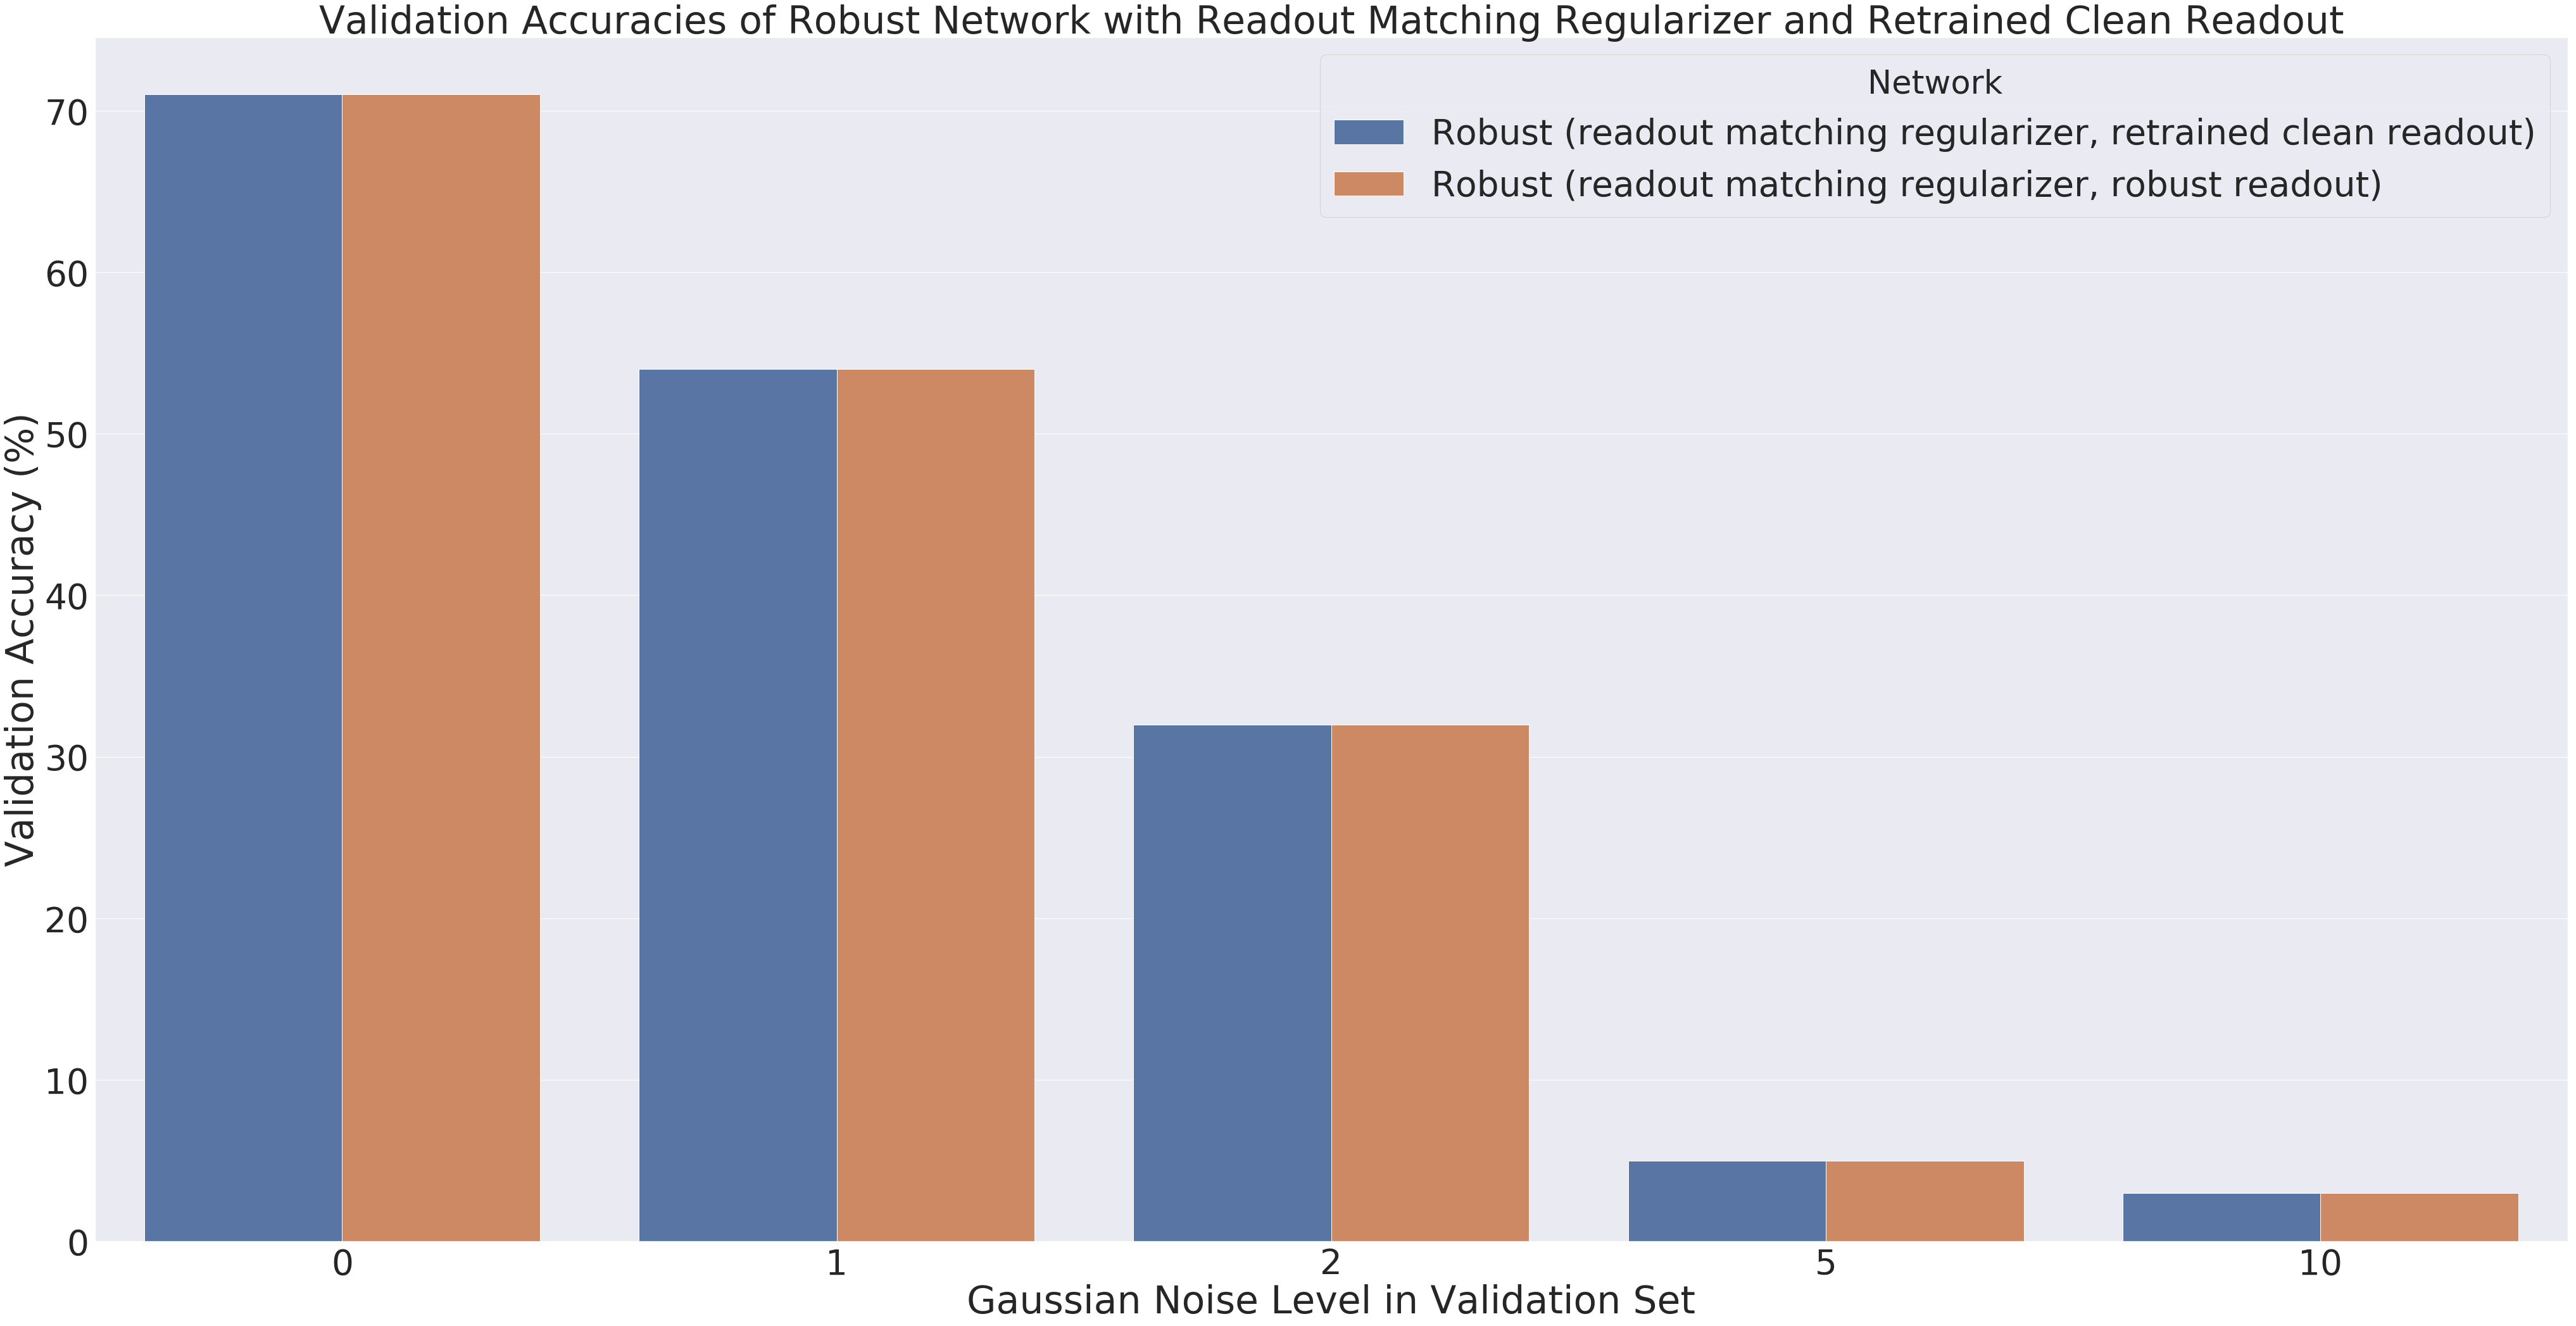

In [189]:
plt.figure(figsize=(70,35))
sns.set(font_scale=5)
#sns.set_context(font_scale=40.0)
fig = sns.barplot(x="Noise Level in Testing/Validation Set", y="Validation Accuracy (%)", hue="Network", data=df4)
fig.set_xlabel("Gaussian Noise Level in Validation Set")
fig.set_title("Validation Accuracies of Robust Network with Readout Matching Regularizer and Retrained Clean Readout")
plt.savefig("readout_matching_accuracies")

In [190]:
df5 = pd.read_csv("Subplot - Sheet2.csv")

In [191]:
df5

Noise Level  Accuracy                          Network
0            0        65             Robust Unregularized
1            1        62             Robust Unregularized
2            2        54             Robust Unregularized
3            5        23             Robust Unregularized
4           10        11             Robust Unregularized
5            0        71  Similarity Matching Regularized
6            1        15  Similarity Matching Regularized
7            2         2  Similarity Matching Regularized
8            5         1  Similarity Matching Regularized
9           10         1  Similarity Matching Regularized

In [207]:
df5

Noise Level  Accuracy                               Network
0            0        70  Robust, Readout Matching Regularized
1            1        58  Robust, Readout Matching Regularized
2            2        28  Robust, Readout Matching Regularized
3            5         9  Robust, Readout Matching Regularized
4           10         4  Robust, Readout Matching Regularized
5            0        71       Similarity Matching Regularized
6            1        15       Similarity Matching Regularized
7            2         2       Similarity Matching Regularized
8            5         1       Similarity Matching Regularized
9           10         1       Similarity Matching Regularized

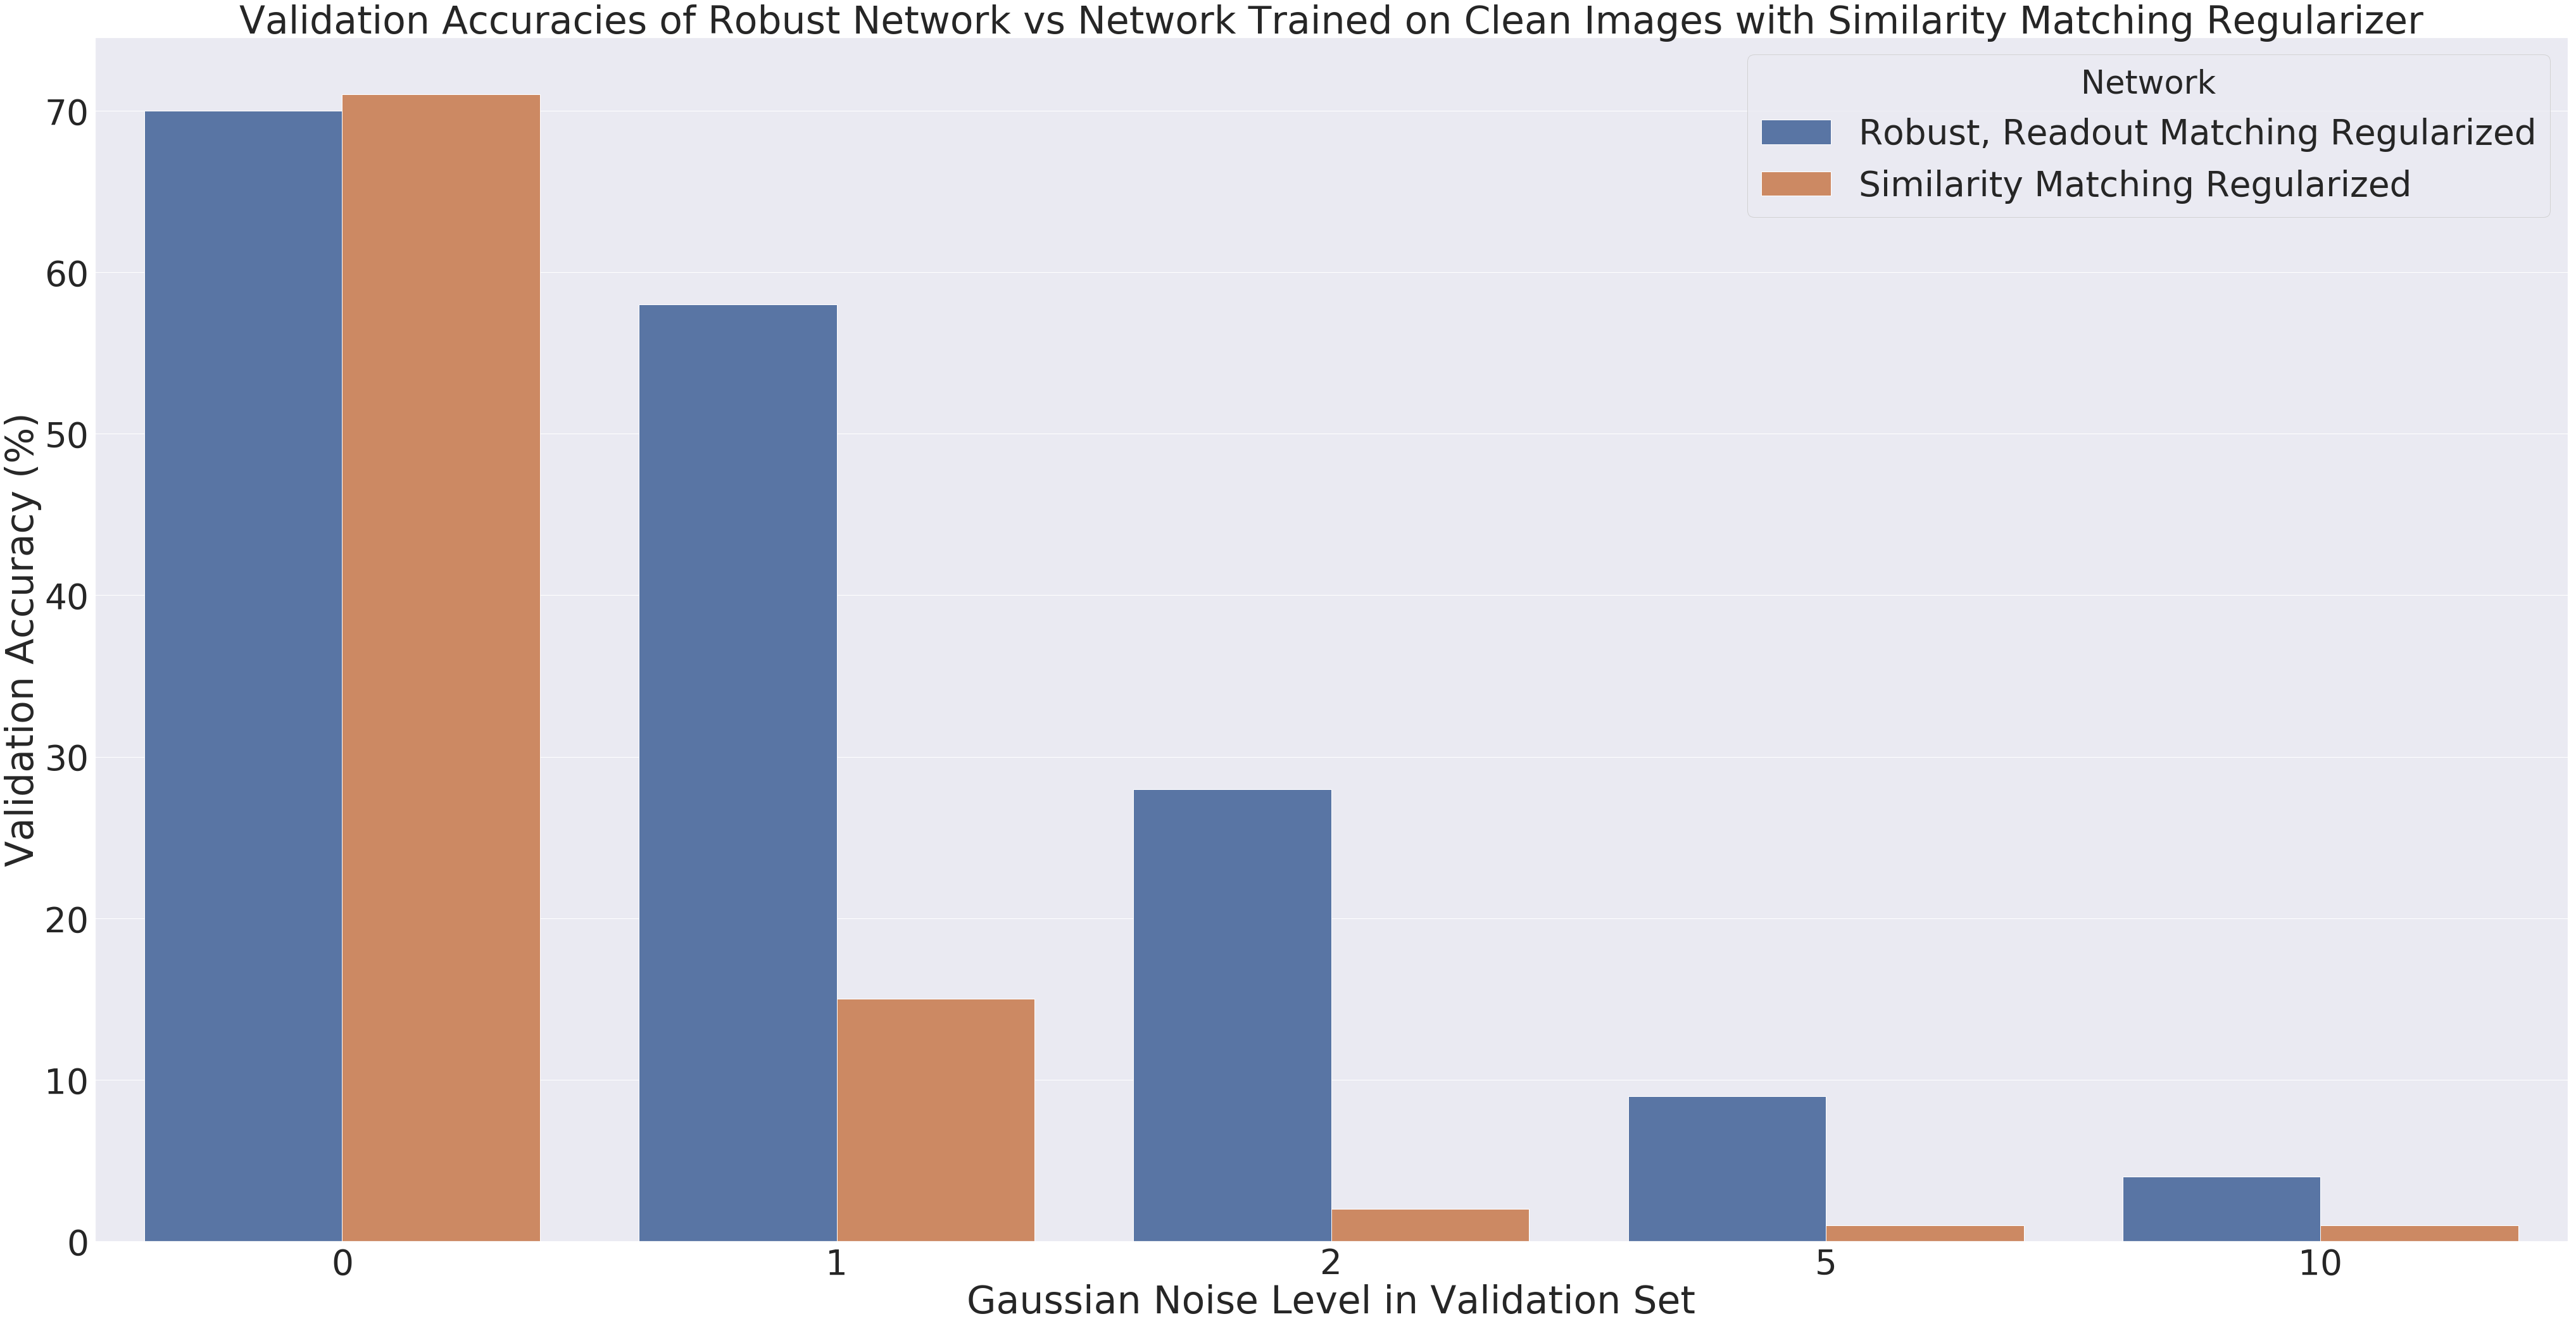

In [211]:
plt.figure(figsize=(70,35))
sns.set(font_scale=5)
#sns.set_context(font_scale=40.0)
fig = sns.barplot(x="Noise Level", y="Accuracy", hue="Network", data=df5)
fig.set_xlabel("Gaussian Noise Level in Validation Set")
fig.set_ylabel("Validation Accuracy (%)")
fig.set_title("Validation Accuracies of Robust Network vs Network Trained on Clean Images with Similarity Matching Regularizer")
plt.savefig("robust_vs_similarity")

In [212]:
[1:2]

SyntaxError: invalid syntax (<ipython-input-212-1c7b5ee1ef5d>, line 1)

In [232]:
torch.Tensor([2,4]).normal_()

tensor([1.3491, 0.2836])

In [234]:
x = torch.rand([128,3,32,32])

In [240]:
import random

In [252]:
torch.Tensor([random.choice([0,1,2,5,10]) for i in range(0,128)]).unsqueeze(dim=0)*x

RuntimeError: The size of tensor a (128) must match the size of tensor b (32) at non-singleton dimension 3

In [286]:
s = torch.tensor(random.choice([0,1,2,5,10])).repeat(128)

In [287]:
s

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

In [280]:
s

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])

In [2]:
    checkpoint = torch.load('./checkpoint/'+args.dataset+os.sep+file_name+'_gaussianRand.t7')


NameError: name 'args' is not defined

In [61]:
df5 = pd.read_csv('./plotting data/Robust Network Trained on Proper Images - Sheet1.csv')

In [62]:
df5

Noise Level  Accuracy             Readout Type
0            0        69  noise-augmented readout
1            1        55  noise-augmented readout
2            2        32  noise-augmented readout
3            5        12  noise-augmented readout
4           10         5  noise-augmented readout
5            0        69            clean readout
6            1        55            clean readout
7            2        32            clean readout
8            5        12            clean readout
9           10         5            clean readout

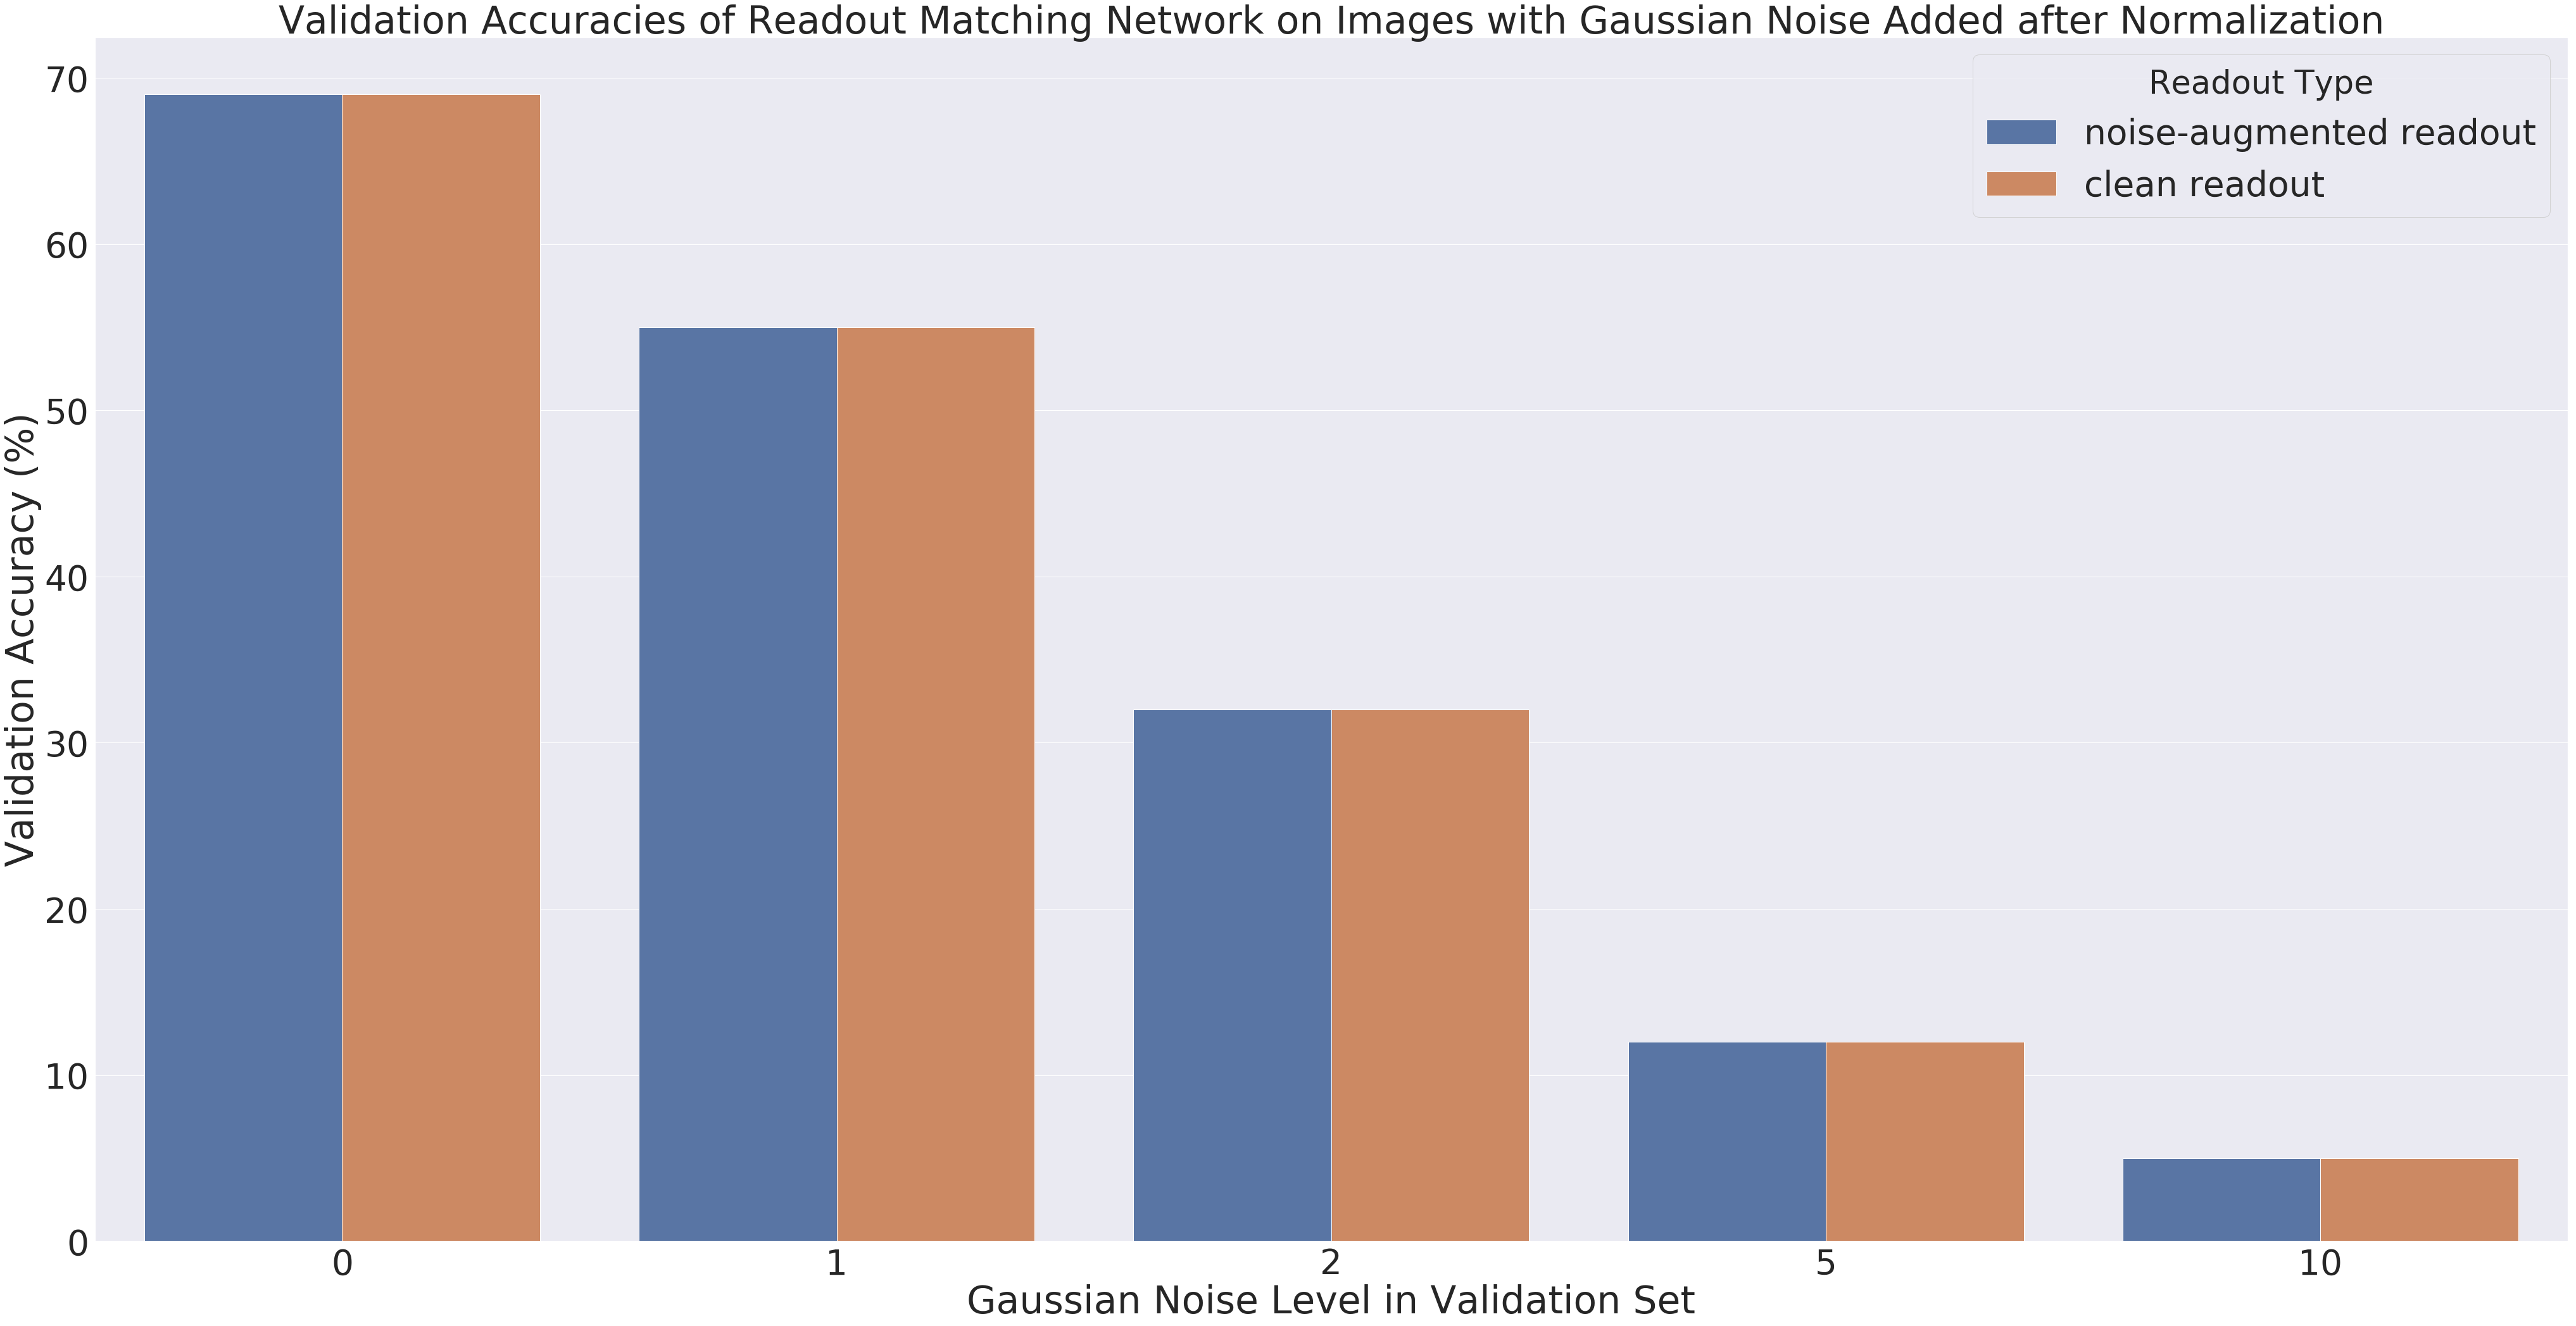

In [65]:
plt.figure(figsize=(70,35))
sns.set(font_scale=5)
#sns.set_context(font_scale=40.0)
fig = sns.barplot(x="Noise Level", y="Accuracy", hue="Readout Type", data=df5)
fig.set_xlabel("Gaussian Noise Level in Validation Set")
fig.set_ylabel("Validation Accuracy (%)")
fig.set_title("Validation Accuracies of Readout Matching Network on Images with Gaussian Noise Added after Normalization")
plt.savefig('./plots/readout_matching_properTransformation')

In [2]:
df6 = pd.read_csv('./plotting data/Accuracy vs Eta - Sheet1.csv')

In [3]:
df6

Noise Level  Accuracy    Eta
0             0        65  0.005
1             1        32  0.005
2             2         6  0.005
3             5         1  0.005
4            10         1  0.005
5             0        63  0.010
6             1        34  0.010
7             2         5  0.010
8             5         1  0.010
9            10         1  0.010
10            0        58  0.020
11            1        34  0.020
12            2         7  0.020
13            5         1  0.020
14           10         1  0.020
15            0        59  0.040
16            1        29  0.040
17            2         5  0.040
18            5         1  0.040
19           10         1  0.040
20            0        48  0.080
21            1        21  0.080
22            2         3  0.080
23            5         1  0.080
24           10         1  0.080

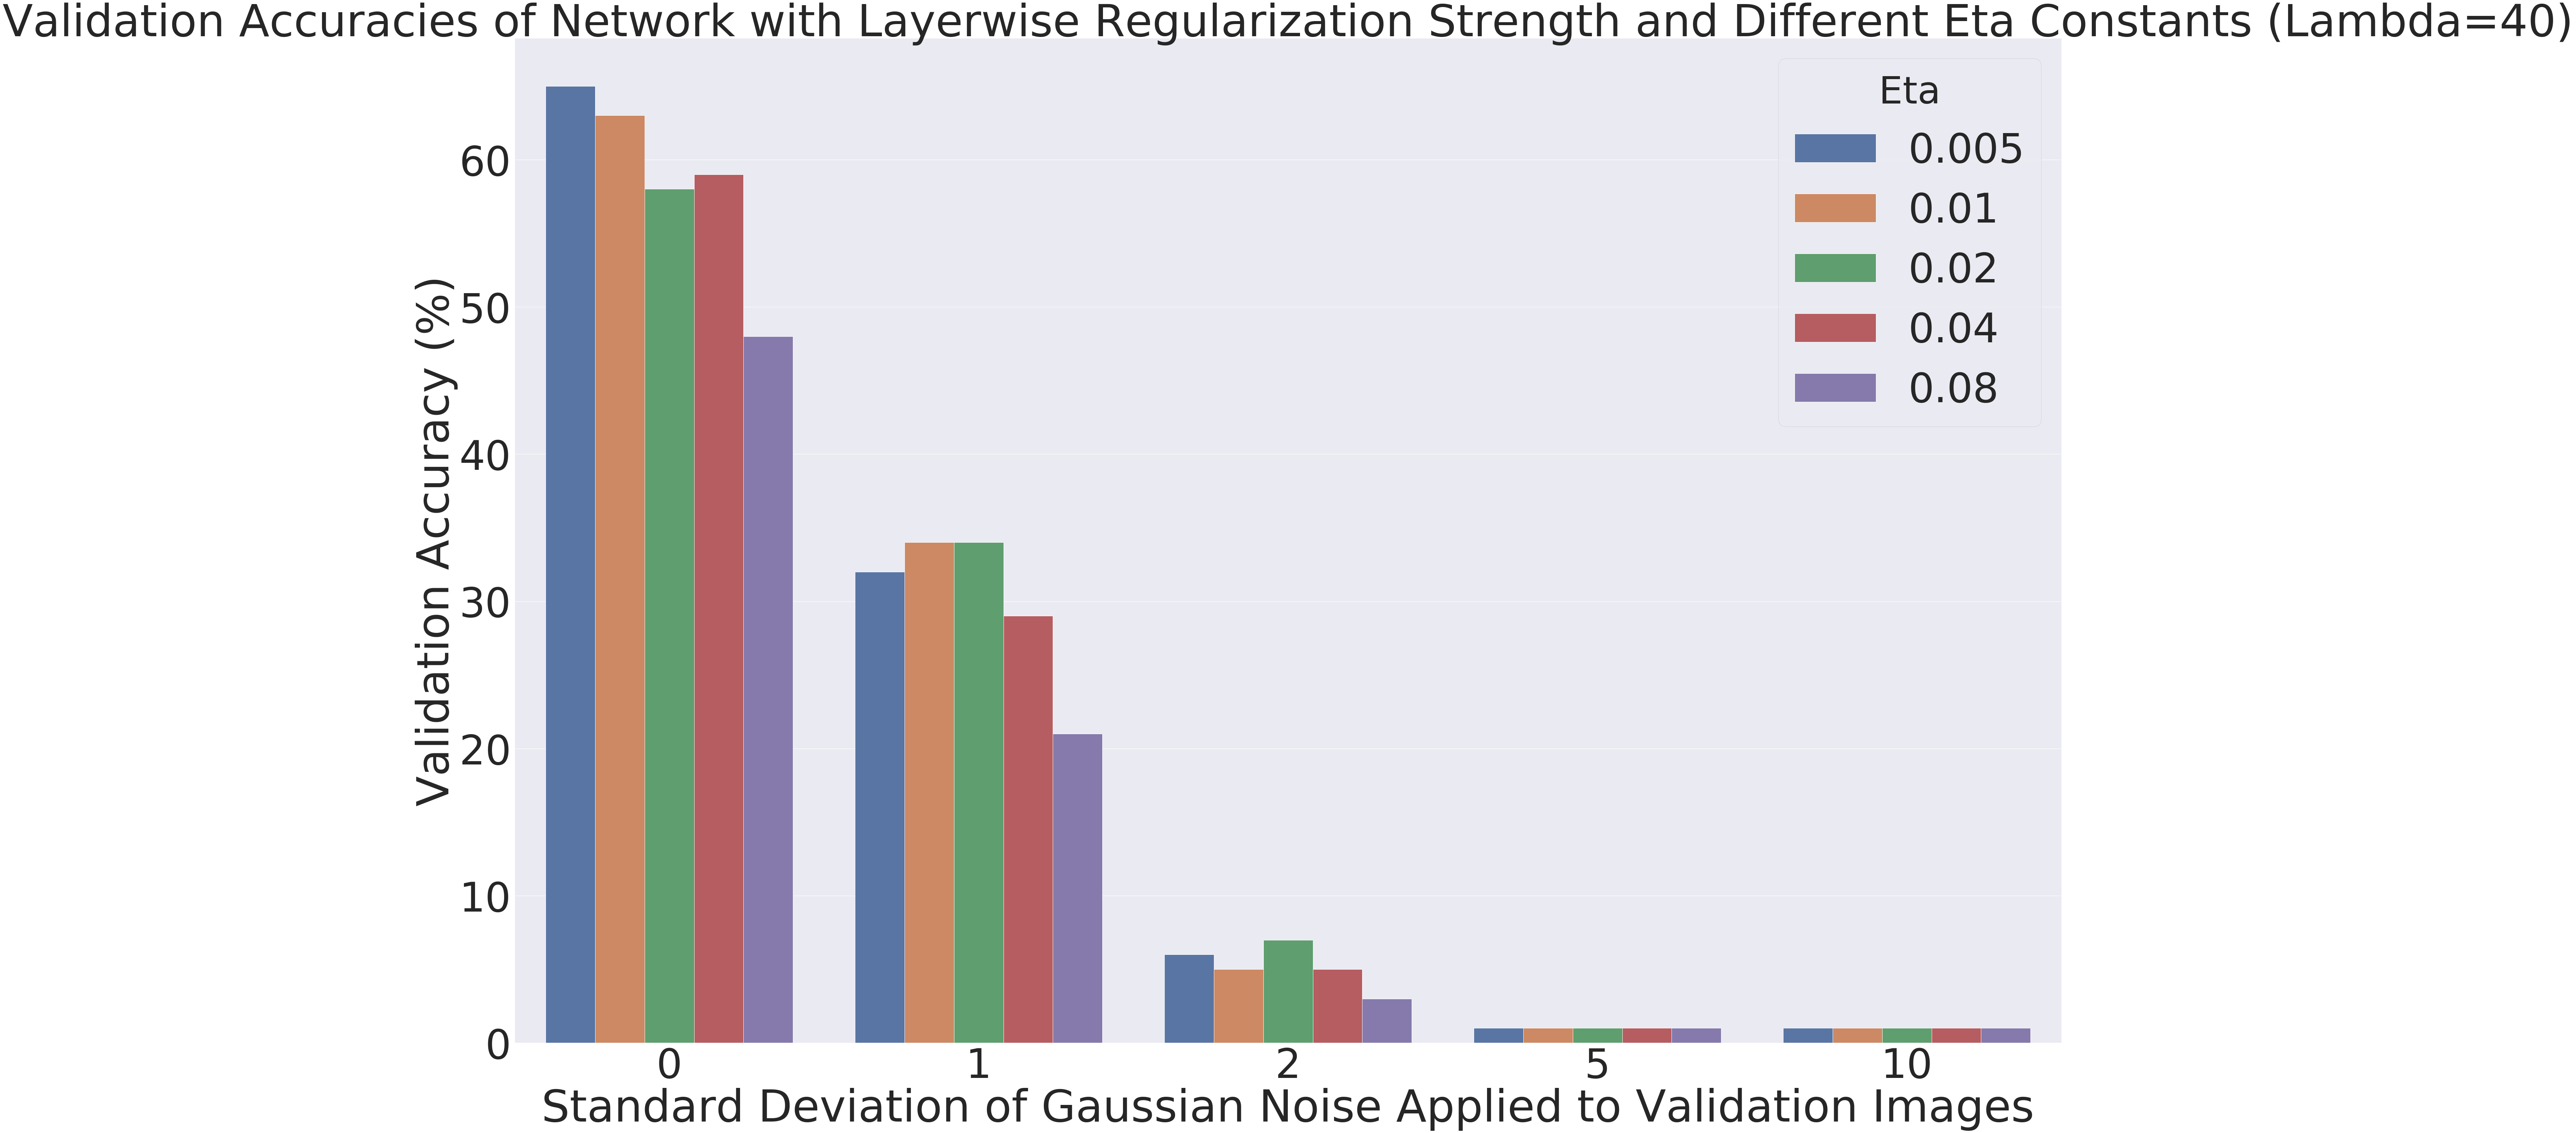

In [18]:
plt.figure(figsize=(75,50))
sns.set(font_scale=10
       )
fig = sns.barplot(x="Noise Level", y="Accuracy", hue="Eta", data=df6)
fig.set_xlabel("Standard Deviation of Gaussian Noise Applied to Validation Images")
fig.set_ylabel("Validation Accuracy (%)")
fig.set_title("Validation Accuracies of Network with Layerwise Regularization Strength and Different Eta Constants (Lambda=40)")
plt.savefig("Eta_vs_accuracy_lambda40")

In [188]:
import numpy as np

In [201]:
readloss1 = np.load('epoch_readout_loss.npy')
readloss2 = np.load('epoch_readout_loss_multiStep.npy')

In [211]:
readloss2

array([0.47438505, 0.45417398, 1.49546754, 1.25672925, 2.59977221,
       1.86049676, 0.90121108, 0.64600134, 0.29973927, 0.26672438,
       0.16238785, 0.08930132, 0.05478178, 0.04017609, 0.02501403,
       0.02143495, 0.01590254, 0.0136099 , 0.01520489, 0.01272955,
       0.01404149, 0.01851007, 0.01191215, 0.01064375, 0.01199814,
       0.00913148, 0.00909405, 0.0117085 , 0.01021094, 0.01014584,
       0.00996551, 0.0102228 , 0.01308328, 0.01130059, 0.01374691,
       0.0124843 , 0.01354001, 0.01256211, 0.01404344, 0.01302337,
       0.01597525, 0.01710767, 0.01902737, 0.01517638, 0.0151795 ,
       0.02335135, 0.02515705, 0.02375201, 0.02687559, 0.02652819,
       0.02601786, 0.02403421, 0.0247665 , 0.02574077, 0.03029796,
       0.02882251, 0.02974956, 0.03044693, 0.02947192, 0.03224991,
       0.03668243, 0.03639114, 0.03618899, 0.03284492, 0.03379786,
       0.03299166, 0.0335341 , 0.0370769 , 0.02969443, 0.04469655,
       0.03678026, 0.04241295, 0.04364924, 0.0393463 , 0.03715

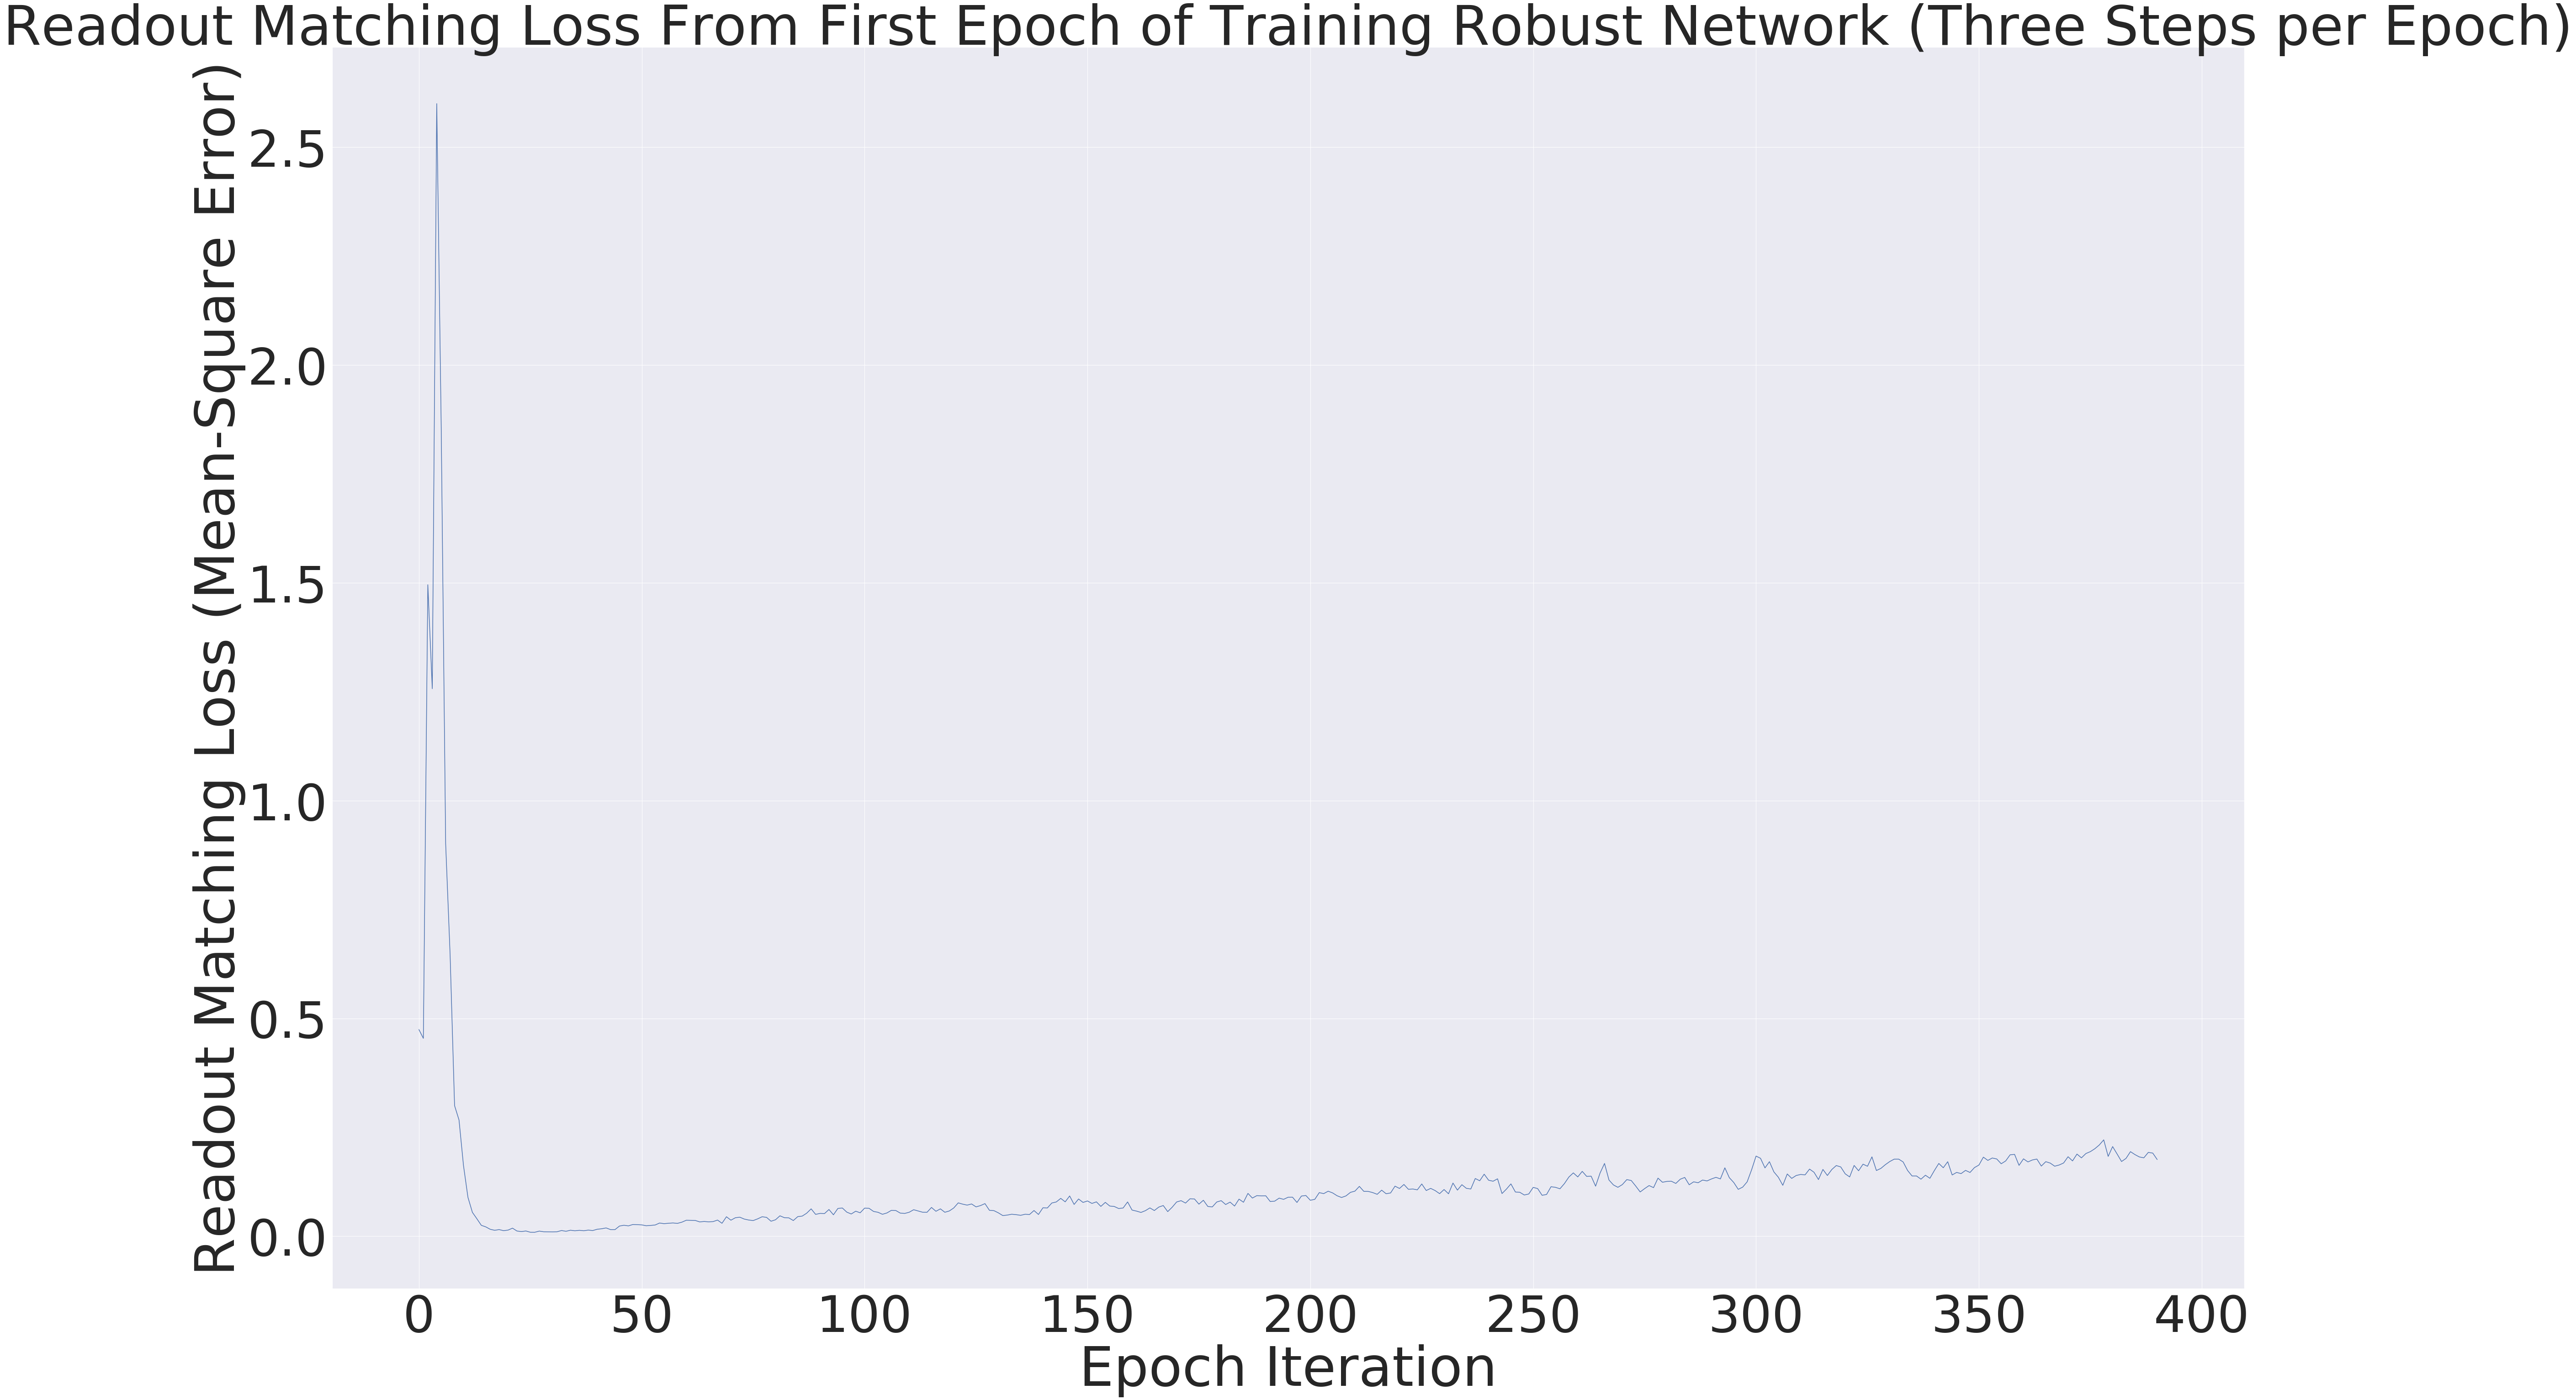

In [210]:
plt.figure(figsize=(75,50))
sns.set(font_scale=10
       )
fig = sns.lineplot(range(0, len(readloss2)),readloss2)
fig.set_xlabel("Epoch Iteration")
fig.set_ylabel("Readout Matching Loss (Mean-Square Error)")
fig.set_title("Readout Matching Loss From First Epoch of Training Robust Network (Three Steps per Epoch)")
plt.savefig("readout_loss_plot2")